In [1]:
import cmath
import math
from iminuit.cost import LeastSquares
from iminuit import cost
from iminuit import Minuit, cost
import numpy as np
from matplotlib import pyplot as plt
import h5py
from PIL import Image
import scipy.special as ss
import scipy.constants as sc

def ampl(i, q):
    return np.power((np.power(q, 2) + np.power(i, 2)), 1/2)

def phase(i, q):
    return(np.arctan(q / i))

def amp_model(x, p1 , p2 , p3, p4, p5, p6,  p7, p8):
    return (p6*(x) + p7*x**2 + p8*x**3) + abs(p1*(1 - cmath.exp(1j*p4)*p2*(p2**-1 - p3**-1) / (1 + 2j * p2 * ( x - p5 ) / f_min[0] )))

def new_amp_model(x, p1, p2 , p3, p4, p5, p6,  p7, p8):
    return (p6*x + p7*x**2 + p8*x**3) + p1 * abs ((1 - (1 - p2 / p3) * cmath.exp(1j*p4) / (1 + 2j * p2 * ( x - p5 ) / p5 )))

def inv_Qi_model(x, p1, p2, p3, p4):        # DOVETE CAPIRE QUALE SIA IL SEGNO DELL'ARG DI I_0
    return  1/p1 + (2*p2*np.exp(-p3/(sc.k*x))*2*np.sinh(sc.hbar*p4/(2*sc.k*x))*ss.kv(0, sc.hbar*p4/(2*sc.k*x)))/(np.pi*(1-2*np.exp(-p3/(sc.k*x))*np.exp(-sc.hbar*p4/(2*sc.k*x))*ss.iv(0,sc.hbar*p4/(2*sc.k*x))))

def plot_amp_and_phase(i, q, f, number_res):        # Plots the amplitude vs f and phase vs f for a single resonator given the i, q, f values
    fig, (ax1, ax2) = plt.subplots(1, 2)            # And that's for the resonator number 'number_res + 1'
    fig.suptitle("Plots relative to the resonator number " + str(number_res + 1) + "\n\n\n")

    ax1.plot(f, amp, label = 'Amplitude vs f')
    ax1.set_title( "Amplitude")
    ax1.set_xlabel("f [GHz]")
    ax1.set_ylabel("Amplitude")

    fig.subplots_adjust(wspace=.4)

    ax2.set_title("Phase")
    ax2.set_xlabel("f [GHz]")
    ax2.set_ylabel("$\Phi \; [rad]$")

    plt.plot(f, phase(i, q), label = 'Phase vs f')
    plt.show()
    
def get_single_res_data(h5file, temp, freq_window, number_res):     # Allows to get important data from the hdf5 file
    f1 = freq_window[number_res * 2]
    f2 = freq_window[number_res * 2 + 1]
    f = h5file['Temp_' + str(temp) + 'mK']['temp_' + str(temp) + 'mK_Start' + str(f1) + '_Stop' + str(f2) + 'GHz']['freqs'][number_res, :]*1e9
    i = h5file['Temp_' + str(temp) + 'mK']['temp_' + str(temp) + 'mK_Start' + str(f1) + '_Stop' + str(f2) + 'GHz']['I'][:]
    q = h5file['Temp_' + str(temp) + 'mK']['temp_' + str(temp) + 'mK_Start' + str(f1) + '_Stop' + str(f2) + 'GHz']['Q'][:]
    return f, i, q

def plot_data_and_fit(freqs, original_data, fitted_points, original_data_err = 0., x_axis = 'frequency [GHz]', y_axis = 'magnitude $S_{21}$', title = 'Amplitude vs frequency'):     # Plots superposition of fit and data
    plt.errorbar(freqs, original_data, yerr = original_data_err, xerr=None, marker='o', markersize=.8, barsabove=True, elinewidth=.8, capsize=.8, linewidth=0, label = 'data')
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.plot(freqs, fitted_points, label = 'fit')
    #plt.xlim(-0.0015, 0.0015)
    #plt.title('Superposition of original data and fit')
    plt.show()

def fit_check(m):
    valid, accurate = m.valid, m.accurate
    return valid, accurate

def new_fit(f, amp, amp_err, new_amp_model): # new fit which is performed without frequency tranlsation
    least_squares = LeastSquares(f, amp, amp_err, new_amp_model)
    m = Minuit(least_squares, p1 = 1, p2 = 1e4, p3 = 6e4, p4 = -0.5, p5 = 5.5, p6 = -1e2,  p7 = -5e4, p8 = 1e-1)  # starting values for our parameters
    m.limits['p2'] = (1e3, 1e7)
    m.limits['p3'] = (1e3, 1e7)
    m.limits['p5'] = (5.2, 6.0)    
    fit = m.migrad()        #This is the command that performs the fit
    return fit, m  

freq_window = np.array([5.340, 5.355, 5.568, 5.583, 5.667, 5.682, 5.978, 5.987])
    

First we get back the data we had stored in the hdf5 files.
Then we have to try and fit the data regarding the $\textbf{AMPLITUDE}. \\$
We start to handle and clean a bit our data. $\\$
We translate the frequency axis so that the minimum of the resonance curve stays occurs at the frequency zero. The fit should have less trouble if it works with small numbers.
We also rescale the amplitude values in order to get them always lower than 1. The formula which relates $S_{12}$ to the frequency is the following
$\begin{equation}
    S_{21}(f) = I + jQ = P_n(f) \bigg[1 - Q \bigg(\frac{1}{Q} - \frac{1}{Q_i} \bigg) \frac{e^{j \, \Phi_0}}{1 - 2j \, Q \frac{f - f_0}{f_0}} \bigg] =  P_n(f) \bigg[1 -  \bigg( 1 - \frac{Q}{Q_i} \bigg) \frac{e^{j \, \Phi_0}}{1 - 2j \, Q \frac{f - f_0}{f_0}} \bigg]  
\end{equation}$

So, in our model, we will have:
$\begin{equation}
    \begin{cases}
        \; \; p_1 \longrightarrow P_n(f) \\ 
        \; \; p_2 \longrightarrow Q  \hspace{1.5cm} \text{lim}: \; 1e3 < Q < 1e7\\
        \; \; p_3 \longrightarrow Q_i \hspace{1.4cm} \text{lim}: \; 1e3 < Q_i < 1e7\\
        \; \; p_4 \longrightarrow \Phi_0  \\
        \; \; p_5 \longrightarrow f_0 \hspace{1.5cm} \text{lim}: \; 5.2 < f_0 < 6.0\\
        \; \; p_6, \, p_7, \, p_8 \, \longrightarrow \text{coefficients of the polynomial background}
    \end{cases}
\end{equation}$


We are going to fit the module of $S_{21}$, which is the amplitude. And we will also add a polynomial (order $3$) to interpolate the background noise. The model then becomes

$\begin{equation}
    \text{amp} = \text{background} +|S_{21}| = p_6 \,f + p_7 \, f^2 + p_8 \, f^3 + \Bigg| P_n(f) \bigg[1 -  \bigg( 1 - \frac{Q}{Q_i} \bigg) \frac{e^{j \, \Phi_0}}{1 - 2j \, Q \frac{f - f_0}{f_0}} \bigg] \Bigg|
\end{equation}$

How do we associate uncertainties which make sense to our measurements? $\\$

We're going to be interested mainly in $p_3$, which is the $Q_i \, .\\$

Different cells do slightly different things. Read above each cell to understand what it does.

In [16]:

def fit_amp_data(f_transl, amp, amp_err, amp_model):     #Performs the fit on our data for a single resonance
    least_squares = LeastSquares(f_transl, amp, amp_err, amp_model)
    m = Minuit(least_squares, p1 = 1, p2 = 1e3, p3 =  6e4, p4 = -0.5, p5 = 0, p6 = -1e-9,  p7 = -1e-19, p8 = 0)  # starting values for our parameters
    m.limits['p2'] = (1e3, 1e7)
    m.limits['p3'] = (1e2, 1e7)
    m.limits['p5'] = (-0.005*1e9, 0.005*1e9)
    m.limits['p6'] = (-1e-8, 1e-8)
    m.limits['p7'] = (-1e-18, 1e-18)    
    fit = m.migrad()        #This is the command that performs the fit
    return fit, m

#Set parameters to open the correct file and define necessary variables
temps = np.arange(35, 120, 5)  
temps = np.append(temps, np.arange(33, 113, 5))     
temps = np.append(temps, np.arange(118, 208, 5))
temps = np.append(temps, np.arange(208, 258, 10))
temps = np.append(temps, np.arange(278, 358, 10))

temps = np.sort(temps)

amp = np.zeros(1601)
Q_i = np.zeros(shape = (len(temps),4))
Q_i_err = np.zeros(shape = (len(temps),4))
date = np.array(['Feb_16_2023-15_10_57', 'Feb_17_2023-17_42_07','Feb_16_2023-16_06_46', 'Feb_17_2023-10_01_04', 'Feb_17_2023-11_17_43', 'Feb_17_2023-14_19_39', 'Feb_17_2023-15_43_52', 'Feb_17_2023-15_56_04' ])
j = 0           # index that counts the temperatures
res_freqs = np.zeros(4)


for temp in temps:       
    i = 0

    # Open the correct hdf5 file
    while i < len(date):
        try:
            h5file = h5py.File('Values_different_frequency_sweeps_' + str(temp) + 'mK' + str(date[i]) + '.h5', 'r')
            break
        except:
            try: 
                h5file = h5py.File('sweeps_' + str(temp) + 'mK' + str(date[i]) + '.h5', 'r')
                break
            except: i +=1

    # Access the data in the file of the specified temperature. Store the data of all 4 resonators
    for k in range(4):

        f, i, q = get_single_res_data(h5file, temp, freq_window, k)

        # Plot amplitude and phase vs f profiles
        #plot_amp_and_phase(i, q, f, k)
        
        # Normalize and translate the data so the resonance has the minimum at zero  frequency
        amp = ampl(i,q)
        amp = amp / max(amp)
        f_min = f[np.where(amp == min(amp))]
        f_transl = f - f_min

        # Association of uncertainties to our amplitude measures
        if temp%5 == 0:
            amp_err = 0.005 * np.ones(len(f))
        else:
            amp_err = 0.01 * np.ones(len(f))          

        # Perform the fit of the resonance profile with our model
        fit, m = fit_amp_data(f_transl, amp, amp_err, amp_model)
        valid, accurate = fit_check(m)
        if(valid == False or accurate == False):
            print('There has been some trouble with the fit at temperature ' + str(temp) + ' mK of the resonance number ' + str(k+1) +'. \n Make a check!' )
        Q_i[j][k] = fit.values["p3"]
        error_p3 = fit.errors["p3"]
        Q_i_err[j][k] = error_p3

        #Here we can eventually examine some specific cases for certain temperatures

        '''if (temp==45 or temp == 75 or temp == 115):
            print('Il valore di Q_i per la risonanza numero ' + str(1) + ' e per la temperatura ' + str(temp) + 'mK è:' + str(Q_i[j][k]))
            print(fit)
            print('Errore su p3. ' + str(error_p3) + '\n')
            print('Errore su Q_i. ' + str(Q_i_err[j][k]) + '\n')
            print('Risonatore numero', str(k+1))
            plot_data_and_fit(f_transl, amp, amp_model(f_transl, *m.values))
            #print('The value of Qi for the resonator number ' + str(k + 1) + ' is: ' + str(Q_i[k]))'''

        if temp == min(temps):
            res_freqs[k] = f_min
            
    print('Operation on temperature ' + str(temp) + 'mK completed')
    h5file.close()
    j += 1

inv_Q_i = 1 / Q_i
inv_Q_i_err = Q_i_err / Q_i / Q_i
temps = 1e-3*temps      # we have to rescale the temperatures because they have to be expressed in Kelvins (and not mK) when we want to fit


Operation on temperature 33mK completed
Operation on temperature 35mK completed
Operation on temperature 38mK completed
Operation on temperature 40mK completed
Operation on temperature 43mK completed
Operation on temperature 45mK completed
Operation on temperature 48mK completed
Operation on temperature 50mK completed
Operation on temperature 53mK completed
Operation on temperature 55mK completed
Operation on temperature 58mK completed
Operation on temperature 60mK completed
Operation on temperature 63mK completed
Operation on temperature 65mK completed
Operation on temperature 68mK completed
Operation on temperature 70mK completed
Operation on temperature 73mK completed
Operation on temperature 75mK completed
Operation on temperature 78mK completed
Operation on temperature 80mK completed
Operation on temperature 83mK completed
Operation on temperature 85mK completed
Operation on temperature 88mK completed
Operation on temperature 90mK completed
Operation on temperature 93mK completed


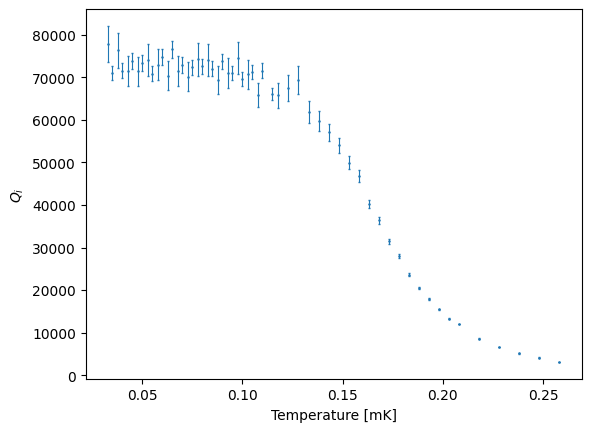

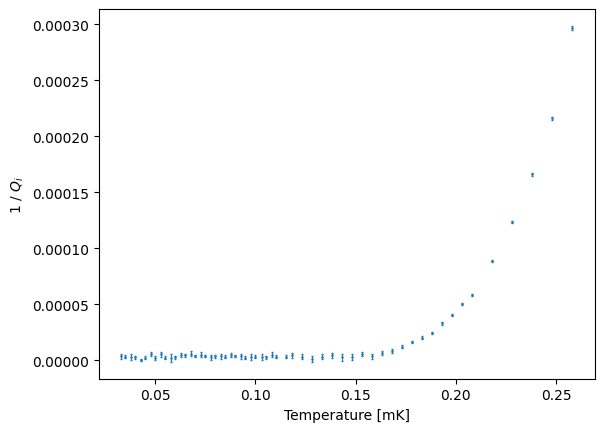

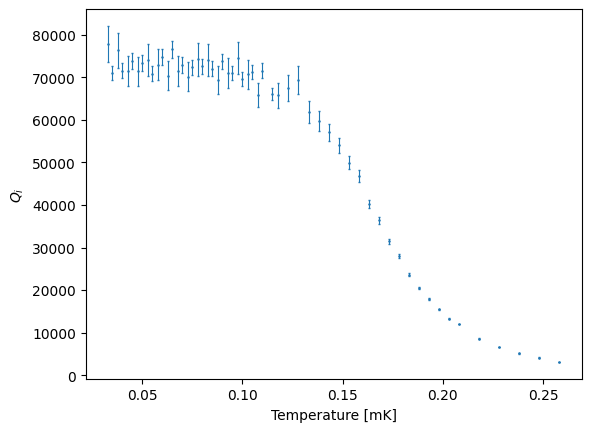

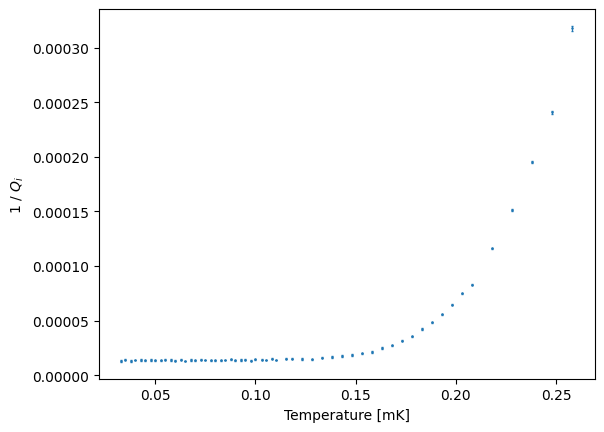

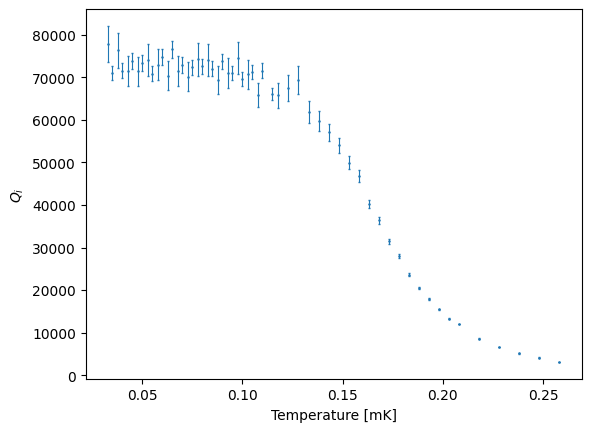

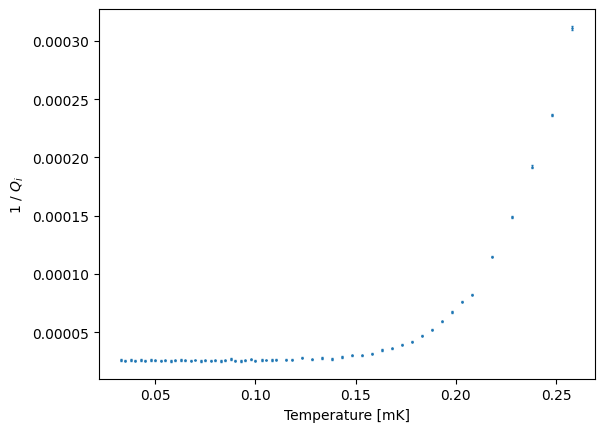

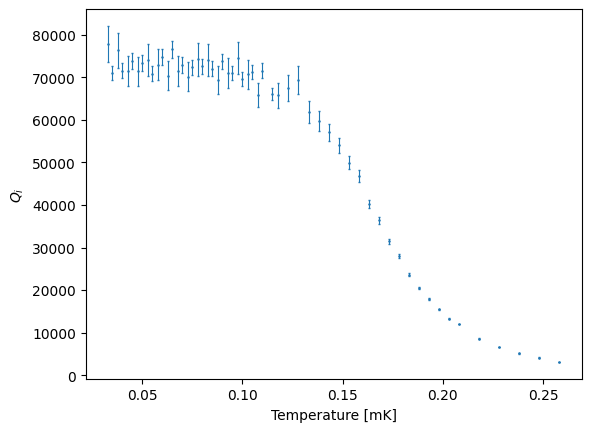

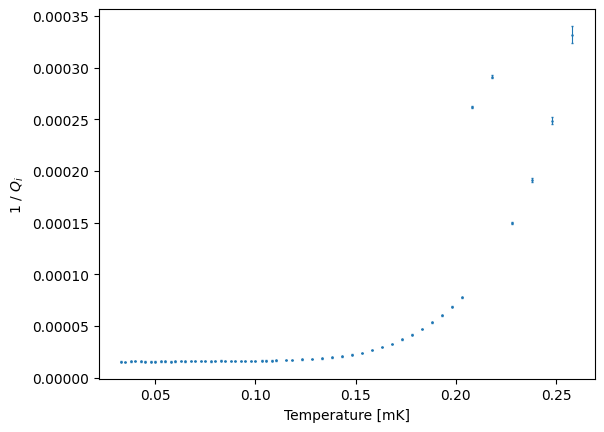

In [3]:
#Use this cell to get a preview of the 1/Q_i distribution vs temperature. In order to fit this data, use the following cell.

for k in range(4):
    plt.errorbar(temps, Q_i[:,1], yerr = Q_i_err[:,1], xerr=None, marker='o', markersize=.8, linewidth=0, barsabove=True, elinewidth=.8, capsize=.8 )
    plt.xlabel('Temperature [mK]')
    plt.ylabel('$Q_i$')
    plt.show()

    plt.errorbar(temps, inv_Q_i[:,k], yerr = inv_Q_i_err[:,k], xerr=None, marker='o', markersize=.8, linewidth=0, barsabove=True, elinewidth=.8, capsize=.8)
    plt.xlabel('Temperature [mK]')
    plt.ylabel('1 / $Q_i$')
    plt.show()

$\color{blue}\textbf{Second fit:} \\$
$\textbf{Remember that you have to mediate on the four resonators sooner or later}$, in order to account for small differences in the vaues stimated for $Q_i$. Now we want to fit the graph we obtained.$\\$
From the second fit we want to get the value of the gap parameter at 0 K $[\Delta(0)]$ for our superconductor.

The interpolating function we will use is $\begin{equation}
\frac{1}{Q_i(T)} = \frac{1}{Q_i(0)} + \frac{\sigma_{1}}{\sigma_{2}} \simeq \frac{1}{Q_i(0)} + \frac{2\alpha}{\pi}\frac{e^{-\frac{\Delta (0)}{k_{B} T}}K_{0}(\frac{\hbar \omega}{2 k_{B} T})\Big[ 2 \sinh (\frac{\hbar \omega}{2 k_{B} T})\Big]}{\Big[1 - 2 e^{-\frac{\Delta (0)}{k_{B}T}}e^{-\frac{\hbar \omega}{2 k_{B} T}} I_{0}(\frac{\hbar \omega}{2 k_{B}T}) \Big]} \end{equation} \\$
Is the $\omega$ the (angular) resonance frequency of the oscillator? In that case it varies with T and you could account for it when you do the fit.


RESONATOR NUMBER  1
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 76.49 (chi2/ndof = 1.4)    │              Nfcn = 350              │
│ EDM = 1.32e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬──────

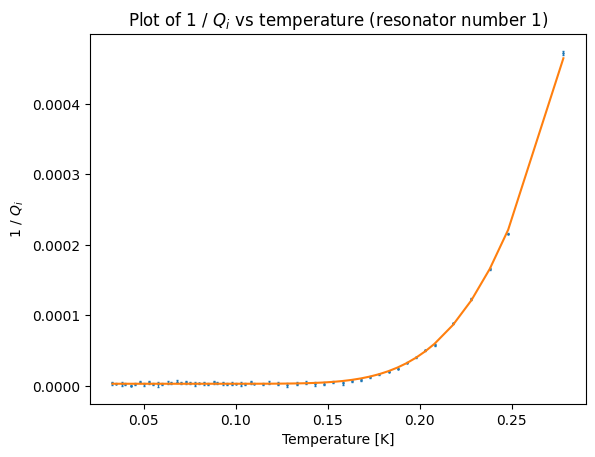

The interpolated value of the gap parameter is: ( 2.4420602578162037e-23 +- 1.146846514980929e-25 ) J
In terms of eV, it is: ( 0.15262876611351275 +- 0.0007167790718630806 ) meV

RESONATOR NUMBER  2
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 473.7 (chi2/ndof = 8.8)    │              Nfcn = 168              │
│ EDM = 1.76e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accu

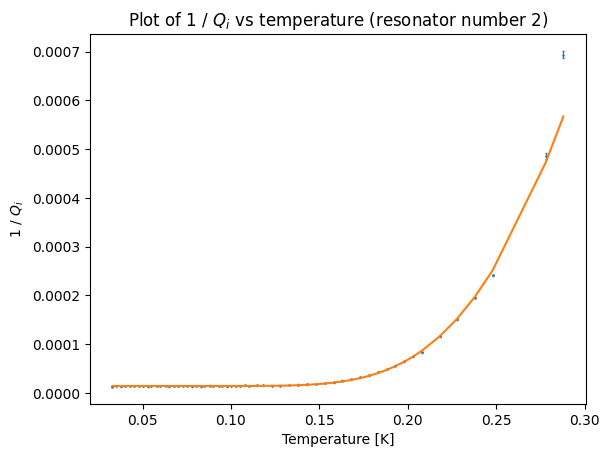

The interpolated value of the gap parameter is: ( 2.1478212445552356e-23 +- 7.798351917777596e-26 ) J
In terms of eV, it is: ( 0.13423882778470222 +- 0.0004873969948610997 ) meV

RESONATOR NUMBER  3
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1503 (chi2/ndof = 28.4)    │              Nfcn = 320              │
│ EDM = 0.000118 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accu

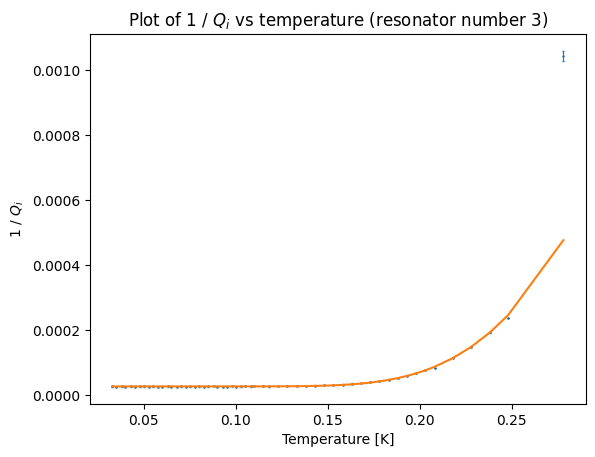

The interpolated value of the gap parameter is: ( 2.3354713655453036e-23 +- 1.1159040294406883e-25 ) J
In terms of eV, it is: ( 0.14596696034658146 +- 0.0006974400184004302 ) meV

RESONATOR NUMBER  4
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.408e+04 (chi2/ndof = 501.6)│              Nfcn = 218              │
│ EDM = 3.35e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ A

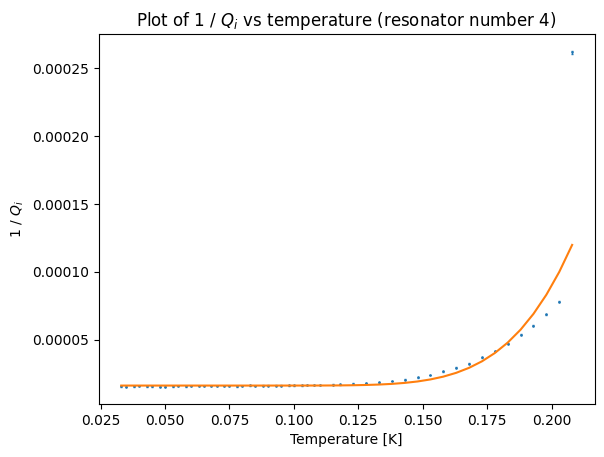

The interpolated value of the gap parameter is: ( 2.5018980077960493e-23 +- 8.113369708469071e-27 ) J
In terms of eV, it is: ( 0.1563686254872531 +- 5.07085606779317e-05 ) meV

Recap:
delta (mev) = [0.15262877 0.13423883 0.14596696 0.15636863]
errors (mev) =  [7.16779072e-04 4.87396995e-04 6.97440018e-04 5.07085607e-05]


In [42]:

def fit_Qi_vs_temp(temp, inv_Q_i, inv_Q_i_err, suggestions):
    least_squares = LeastSquares(temp, inv_Q_i, inv_Q_i_err, inv_Qi_model)
    m = Minuit(least_squares, p1 = suggestions[0 , res], p2 = suggestions[3 , res], p3 = suggestions[6 , res], p4 = suggestions[11, res])  # starting values for our parameters
    m.limits['p1'] = (suggestions[1 , res], suggestions[2 , res])           
    m.limits['p2'] = (suggestions[4 , res], suggestions[5 , res])
    m.limits['p3'] = (suggestions[7 , res], suggestions[8 , res])
    #m.limits['p4'] = ((suggestions[9 , res], suggestions[10 , res]))
    fit = m.migrad()        #This is the command that performs the fit
    return fit, m 

# Erase these lines when you're done with trial and error

suggestions_fit_inv_Q_i = np.zeros(shape=(12, 4))           # Attempt to automatize fit suggestions. Order of the array is: p_i_sugg, p_i_liminf, p_i_limsup for i in [1,3] and in the end p_4_sugg
suggestions_fit_inv_Q_i[:,0] = np.array([1.5e6, 30e3, 1e7, .85, 0.01, 0.99, 2.6e-23, 1.7e-23, 5e-23, 2*np.pi*freq_window[0]*1e9, 2*np.pi*freq_window[1]*1e9, 2* np.pi *5.4e9])
suggestions_fit_inv_Q_i[:,1] = np.array([7e4, 50e3, 90e3, .85, 0.01, 0.99, 2.6e-23, 1.7e-23, 5e-23, 2*np.pi*freq_window[2]*1e9, 2*np.pi*freq_window[3]*1e9, 2* np.pi *5.5e9]) 
suggestions_fit_inv_Q_i[:,2] = np.array([4e4, 30e3, 50e3, .85, 0.01, 0.99, 2.6e-23, 1.7e-23, 5e-23, 2*np.pi*freq_window[4]*1e9, 2*np.pi*freq_window[5]*1e9, 2* np.pi *5.7e9]) 
suggestions_fit_inv_Q_i[:,3] = np.array([6e4, 10e3, 90e3, .85, 0.01, 0.99, 2.6e-23, 1.7e-23, 5e-23, 2*np.pi*freq_window[6]*1e9, 2*np.pi*freq_window[7]*1e9, 2* np.pi *5.8e9])  

# Trying to fit

delta = np.zeros(shape = Q_i[0,:].shape)
delta_err = np.zeros(shape = Q_i[0,:].shape)

res = 0
lim_temp_index = np.array([57, 58, 57, 52])

for k in range(4):

    fit, m = fit_Qi_vs_temp(temps[:lim_temp_index[k]], inv_Q_i[:lim_temp_index[k],k], inv_Q_i_err[:lim_temp_index[k], k], suggestions_fit_inv_Q_i)        # Fit execution

    valid, accurate = fit_check(m)             #Fit check
    print('RESONATOR NUMBER ', k+1)
    if(valid == False or accurate == False):
        print('There has been some trouble with the fit of the resonance number ' + str(k+1) +'. \n Make a check!' )
    print(fit)
    
    plot_data_and_fit(temps[:lim_temp_index[k]], inv_Q_i[:lim_temp_index[k],k], inv_Qi_model(temps[:lim_temp_index[k]], *m.values), original_data_err=inv_Q_i_err[:lim_temp_index[k],k], x_axis = 'Temperature [K]', y_axis = '1 / $Q_i$', title = 'Plot of 1 / $Q_i$ vs temperature (resonator number ' + str(k+1) + ')')
        
    delta[k]= fit.values["p3"]                  #Get the delta parameter
    delta_err[k] = fit.errors["p3"]
    
    print('The interpolated value of the gap parameter is: (', delta[k], '+-', delta_err[k], ') J')
    print('In terms of eV, it is: (', delta[k] / ( 1.6e-19) * 1e3, '+-', delta_err[k] / ( 1.6e-19) * 1e3,') meV\n' )
    res += 1

print('Recap:')
print('delta (mev) =', delta/ ( 1.6e-19) * 1e3)
print('errors (mev) = ', delta_err/ ( 1.6e-19) * 1e3)

In [43]:
gap_measured = np.average(delta[:2]) / (1.6e-19) * 1000 
sqrt_error_gap_measured = np.std(delta[:2]) / (1.6e-19) * 1000

print('The measured value of the gap is (averaged on the 4 reonances and withs std error): (', gap_measured, '+-', sqrt_error_gap_measured, ') mev')

T_c = 1
gap_0K = 1.764 * sc.k * T_c
print('BCS predicts (if T_c =', T_c,  'K) a gap of : ', gap_0K / (1.6e-19) * 1000, 'mev or ', gap_0K, 0 ,'J')



The measured value of the gap is (averaged on the 4 reonances and withs std error): ( 0.1434337969491075 +- 0.00919496916440525 ) mev
BCS predicts (if T_c = 1 K) a gap of :  0.15221655225 mev or  2.4354648360000002e-23 0 J
